# Проект для магазина «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В нашем распоряжении набор данных с разметкой о токсичности правок. Задача - обучить модель классифицировать комментарии на позитивные и негативные.

Требование: значение метрики качества *F1* должно быть не меньше 0.75. 

**Основные шаги**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#чтобы видеть результат на каждой итерации
import sklearn
!pip install scikit-learn==0.24.2
#для облака слов
!/opt/conda/bin/python -m pip install wordcloud 
!pip install --upgrade Pillow
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [2]:
import pandas as pd
import numpy as np
import re 
import os
import pickle
import nltk
import spacy
import matplotlib.pyplot as plt

from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,9)
RANDOM_STATE = 42

In [3]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=0)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=0)
else:
    print('smth went wrong')

,text,toxic
34519,"HJ, do you know approximately how many non-art...",0
72157,"""\n\n Teahouse talkback: you've got messages! \n""",0
111384,"Hello, and welcome to Wikipedia! We welcome an...",0
98544,"Actually, you are the cockroach that followed ...",1
35650,Final Notice to Osli73 \n\nYou can agree or di...,0


Относительная частота классов в целевом признаке:
0    0.898388
1    0.101612
Name: toxic, dtype: float64


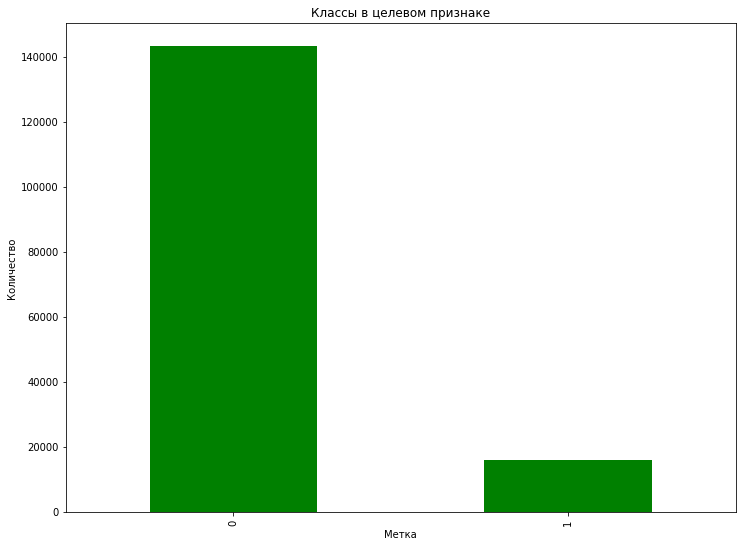

In [4]:
display(data.sample(5))
#display(data.info())

print('Относительная частота классов в целевом признаке:')
print(data['toxic'].value_counts(normalize=True))

data['toxic'].value_counts().plot(kind="bar", color='green');
plt.title('Классы в целевом признаке')
plt.ylabel('Количество')
plt.xlabel('Метка')
plt.show()

Данные загружены: 159292 строки, 2 столбца (текст и метка), пропусков нет. Соотношение значений целевого признака 9:1.

## Обработка данных

Создадим корпус постов. Преобразуем столбец *'text'* в список текстов, переведем в нижний регистр, лемматизируем и очистим от регулярных выражений.

In [5]:
corpus = data['text'].str.lower()

In [6]:
%%time

def clean (text):
    
    clean_text = re.sub(r'[^a-z]', ' ', text)
    clean_text = clean_text.split()
    clean_text = ' '.join(clean_text)
    
    return clean_text

c_text = corpus.apply(clean)
print("Очищенный текст:\n", c_text.head())

Очищенный текст:
 0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object
CPU times: user 4.05 s, sys: 50.5 ms, total: 4.1 s
Wall time: 4.11 s


In [7]:
%%time

def lemm (text):
    
    lemmed = nlp(text)   
    prepaired = " ".join([token.lemma_ for token in lemmed])
       
    return prepaired

nlp = spacy.load('en_core_web_sm')

l_text = c_text.apply(lemm)
print("Лемматизированный текст:", l_text.head())

Лемматизированный текст: 0    explanation why the edit make under my usernam...
1    d aww he match this background colour I m seem...
2    hey man I m really not try to edit war it s ju...
3    more I can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
Name: text, dtype: object
CPU times: user 36min 4s, sys: 10.7 s, total: 36min 15s
Wall time: 36min 16s


Сохраним получившийся текст в файл, чтобы не выполнять 30-минутные вычисления снова.

In [8]:
with open('comments', 'wb') as handle:
    pickle.dump(l_text, handle)

In [9]:
with open('comments', 'rb') as handle:
    words = pickle.load(handle)

Построим облако слов, чтобы получить представление об общей тематике текстов, токсичных и нетоксичных.

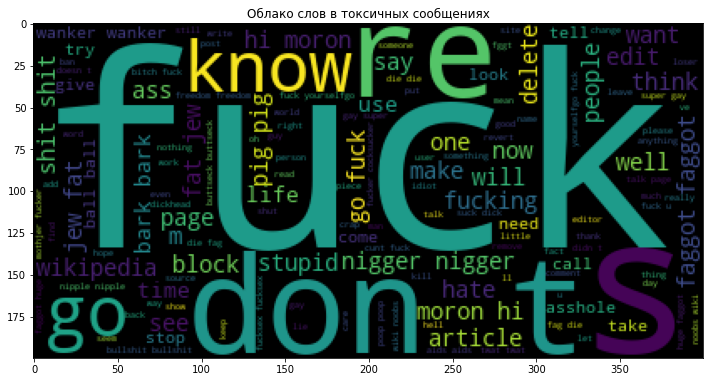

In [10]:
toxic_words = l_text[data['toxic']==1].apply(lambda x: x.split())
toxic_words = [y for x in toxic_words for y in x]

toxic_words = ' '.join(toxic_words)
toxic_wordcloud = WordCloud(background_color="black").generate(toxic_words)

plt.imshow(toxic_wordcloud)
plt.title('Облако слов в токсичных сообщениях')
plt.show()

Токсичненько.

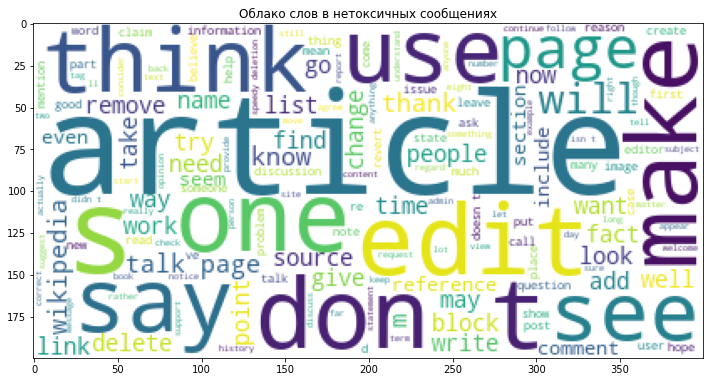

In [11]:
non_toxic_words = l_text[data['toxic']==0].apply(lambda x: x.split())
non_toxic_words = [y for x in non_toxic_words for y in x]

non_toxic_words = ' '.join(non_toxic_words)
non_toxic_wordcloud = WordCloud(background_color="white").generate(non_toxic_words)

plt.imshow(non_toxic_wordcloud)
plt.title('Облако слов в нетоксичных сообщениях')
plt.show()

А тут безобидно.

Разделим тексты на выборки, чтобы при векторизации значения из тестовой не загрязнили тренировочную.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(words, data['toxic'], test_size=0.2, 
                                                    random_state=RANDOM_STATE, stratify=data['toxic'])

Убедимся, что баланс классов в тренировочной и тестовой одинаков.

In [13]:
print('Относительная частота классов в целевом признаке:')
print('train:\n', y_train.value_counts(normalize=True))
print('test:\n', y_test.value_counts(normalize=True))

Относительная частота классов в целевом признаке:
train:
 0    0.898386
1    0.101614
Name: toxic, dtype: float64
test:
 0    0.898396
1    0.101604
Name: toxic, dtype: float64


In [14]:
for chunk in [X_train, X_test, y_train, y_test]:
    print(chunk.shape)

(127433,)
(31859,)
(127433,)
(31859,)


In [15]:
nltk.download('stopwords') 
stopwords = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Векторизируем.

In [16]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [17]:
%%time
X_train_tf_idf = count_tf_idf.fit_transform(X_train)
X_test_tf_idf = count_tf_idf.transform(X_test)

CPU times: user 6.07 s, sys: 48 ms, total: 6.12 s
Wall time: 6.13 s


Данные готовы к обучению моделей.

## Обучение

Попробуем разные модели - наивный байесовский классификатор, логистическую регрессию, стохастический градиентный спуск и LGBM с подбором гиперпараметров. Для последнего будем использовать RandomizedSearchCV из-за большого времени расчета.

In [18]:
model_list = ['NBC', 'LR', 'SGD', 'LGB']
result_train_list = []

In [19]:
#модели
model_NBC = Pipeline([('tfidf', count_tf_idf), ('clf', ComplementNB())])
model_LR = Pipeline([('tfidf', count_tf_idf), ('clf', LogisticRegression(random_state=RANDOM_STATE))])
model_SGD = Pipeline([('tfidf', count_tf_idf), ('clf', SGDClassifier(random_state=RANDOM_STATE))])
model_LGB = Pipeline([('tfidf', count_tf_idf), ('clf', LGBMClassifier(random_state=RANDOM_STATE))])

In [20]:
#функция для работы модели с подбором параметров
def model_run(model, params, x_train, y_train):
    if type(model[1]) == LGBMClassifier:
        model_opt = RandomizedSearchCV(model, params, random_state=RANDOM_STATE, cv=3, n_jobs=-1, scoring='f1', verbose=10)
    else:
        model_opt = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='f1', verbose=10)
    model_opt.fit(x_train, y_train)
    return model_opt.best_score_, model_opt.best_estimator_  

In [21]:
#наборы параметров
param_NBC = {'clf__alpha': [0.2, 0.25, 0.3, 0.35, 0.4, 1]}
param_LR = {'clf__C': [0.1, 1, 5, 10, 15, 30, 100]}
param_SGD = {'clf__max_iter': [15, 20, 30, 500], 'clf__alpha': [ 0.000001, 0.000005, 0.00001],
             'clf__n_iter_no_change': [9, 11, 13], 'clf__penalty': ['l2', 'l1']}
param_LGB = {'clf__n_estimators': [500, 2000, 5000, 6000], 'clf__max_depth': [2, 3, 5, 7], 'clf__num_leaves': [31, 41, 51]}

In [22]:
%%time
result_NBC = model_run(model_NBC, param_NBC, X_train, y_train)
result_train_list.append(result_NBC[0])
print(result_NBC)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START clf__alpha=0.2..............................................
[CV 1/3; 1/6] END ...............clf__alpha=0.2;, score=0.675 total time=   5.0s
[CV 2/3; 1/6] START clf__alpha=0.2..............................................
[CV 2/3; 1/6] END ...............clf__alpha=0.2;, score=0.676 total time=   5.0s
[CV 3/3; 1/6] START clf__alpha=0.2..............................................
[CV 3/3; 1/6] END ...............clf__alpha=0.2;, score=0.675 total time=   5.2s
[CV 1/3; 2/6] START clf__alpha=0.25.............................................
[CV 1/3; 2/6] END ..............clf__alpha=0.25;, score=0.676 total time=   5.1s
[CV 2/3; 2/6] START clf__alpha=0.25.............................................
[CV 2/3; 2/6] END ..............clf__alpha=0.25;, score=0.678 total time=   5.1s
[CV 3/3; 2/6] START clf__alpha=0.25.............................................
[CV 3/3; 2/6] END ..............clf__alpha=0.25;,

In [23]:
%%time
result_LR = model_run(model_LR, param_LR, X_train, y_train)
result_train_list.append(result_LR[0])
print(result_LR)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3; 1/7] START clf__C=0.1..................................................
[CV 1/3; 1/7] END ...................clf__C=0.1;, score=0.478 total time=  15.8s
[CV 2/3; 1/7] START clf__C=0.1..................................................
[CV 2/3; 1/7] END ...................clf__C=0.1;, score=0.472 total time=  19.6s
[CV 3/3; 1/7] START clf__C=0.1..................................................
[CV 3/3; 1/7] END ...................clf__C=0.1;, score=0.481 total time=  17.7s
[CV 1/3; 2/7] START clf__C=1....................................................
[CV 1/3; 2/7] END .....................clf__C=1;, score=0.720 total time=  37.5s
[CV 2/3; 2/7] START clf__C=1....................................................
[CV 2/3; 2/7] END .....................clf__C=1;, score=0.726 total time=  41.1s
[CV 3/3; 2/7] START clf__C=1....................................................
[CV 3/3; 2/7] END .....................clf__C=1;,

In [24]:
%%time
result_SGD = model_run(model_SGD, param_SGD, X_train, y_train)
result_train_list.append(result_SGD[0])
print(result_SGD)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3; 1/72] START clf__alpha=1e-06, clf__max_iter=15, clf__n_iter_no_change=9, clf__penalty=l2
[CV 1/3; 1/72] END clf__alpha=1e-06, clf__max_iter=15, clf__n_iter_no_change=9, clf__penalty=l2;, score=0.759 total time=   5.5s
[CV 2/3; 1/72] START clf__alpha=1e-06, clf__max_iter=15, clf__n_iter_no_change=9, clf__penalty=l2
[CV 2/3; 1/72] END clf__alpha=1e-06, clf__max_iter=15, clf__n_iter_no_change=9, clf__penalty=l2;, score=0.768 total time=   5.5s
[CV 3/3; 1/72] START clf__alpha=1e-06, clf__max_iter=15, clf__n_iter_no_change=9, clf__penalty=l2
[CV 3/3; 1/72] END clf__alpha=1e-06, clf__max_iter=15, clf__n_iter_no_change=9, clf__penalty=l2;, score=0.760 total time=   5.5s
[CV 1/3; 2/72] START clf__alpha=1e-06, clf__max_iter=15, clf__n_iter_no_change=9, clf__penalty=l1
[CV 1/3; 2/72] END clf__alpha=1e-06, clf__max_iter=15, clf__n_iter_no_change=9, clf__penalty=l1;, score=0.753 total time=   5.7s
[CV 2/3; 2/72] START clf__alph

In [25]:
%%time
result_LGB = model_run(model_LGB, param_LGB, X_train, y_train)
result_train_list.append(result_LGB[0])
print(result_LGB)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START clf__max_depth=5, clf__n_estimators=2000, clf__num_leaves=31
[CV 1/3; 1/10] END clf__max_depth=5, clf__n_estimators=2000, clf__num_leaves=31;, score=0.778 total time= 5.1min
[CV 2/3; 1/10] START clf__max_depth=5, clf__n_estimators=2000, clf__num_leaves=31
[CV 2/3; 1/10] END clf__max_depth=5, clf__n_estimators=2000, clf__num_leaves=31;, score=0.775 total time= 5.3min
[CV 3/3; 1/10] START clf__max_depth=5, clf__n_estimators=2000, clf__num_leaves=31
[CV 3/3; 1/10] END clf__max_depth=5, clf__n_estimators=2000, clf__num_leaves=31;, score=0.776 total time= 5.2min
[CV 1/3; 2/10] START clf__max_depth=7, clf__n_estimators=2000, clf__num_leaves=41
[CV 1/3; 2/10] END clf__max_depth=7, clf__n_estimators=2000, clf__num_leaves=41;, score=0.776 total time= 7.2min
[CV 2/3; 2/10] START clf__max_depth=7, clf__n_estimators=2000, clf__num_leaves=41
[CV 2/3; 2/10] END clf__max_depth=7, clf__n_estimators=2000, clf__num_leaves=

In [26]:
result_tab_train = pd.DataFrame({'F1_score train': result_train_list}, index=model_list)
result_tab_train

,F1_score train
NBC,0.677997
LR,0.774811
SGD,0.787884
LGB,0.777613


Худший результат у наивного байесовского классификатора, остальные модели преодолели порог в 0.75, лучший показатель - у стохастического градиентного спуска. 

## Тестирование

Проверим лучшую модель на тестовой выборке.

In [28]:
pred_SGD = result_SGD[1].predict(X_test)
f1_SGD = f1_score(pred_SGD, y_test)
print('F1 на тестовой выборке:', f1_SGD)

F1 на тестовой выборке: 0.7918007792647807


Результат удовлетворяет условию.

## Выводы

**В проекте были рассмотрены тексты описаний товаров и комментариев пользователей в интернет-магазине "Викишоп". Задачей было построить модель, определяющую тональность текста - позитивную или негативную. Критерием оценки была метрика F1.**

**Для выполнения этой задачи тексты были очищены от регулярных выражений, лемматизированы и векторизированы.**

**Далее было рассмотрено несколько моделей классификации для предсказания тональности: наивный байесовский классификатор, логистическая регрессия, стохастический градиентный спуск и LGBMClassifier. Лучший результат показал стохастический градиентный спуск: на тестовой выборке F1 составила 0.79.**